### Data Processing Pipeline for the Telecom Italia Milan Dataset (TIM)

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
import itertools as it
import json
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.ops import nearest_points

from lib.problems import Generator

%matplotlib inline
sns.set()

In [6]:
# Telecom italia data for 1 day (Friday 2013/11/01)
load_pth = "./data/CCP/benchmark/telecom_italia/sms-call-internet-mi-2013-11-01.txt"
grid_pth = "./data/CCP/benchmark/telecom_italia/milano-grid.geojson"
cellid_pth = "./data/CCP/benchmark/telecom_italia/opencellid_2021-08-04_mcc222.csv"
save_grid_pth = "./data/CCP/benchmark/telecom_italia/bs_grid.csv"
save_raw_pth = "./data/CCP/benchmark/telecom_italia/data_aggr_raw.csv"
save_norm_pth = "./data/CCP/benchmark/telecom_italia/"

#### column description

1. Square id: identification string of a given square of Milan/Trentino GRID;

2. Time Interval: start interval time expressed in milliseconds. The end interval time can be obtained by
adding 600,000 milliseconds (10 min) to this value;

3. SMS-in activity: activity proportional to the amount of received SMSs inside a given Square id and
during a given Time interval. The SMSs are sent from the nation identified by the Country code;

4. SMS-out activity: activity proportional to the amount of sent SMSs inside a given Square id during a
given Time interval. The SMSs are received in the nation identified by the Country code;

5. Call-in activity: activity proportional to the amount of received calls inside the Square id during a given
Time interval. The calls are issued from the nation identified by the Country code;

6. Call-out activity: activity proportional to the amount of issued calls inside a given Square id during a
given Time interval. The calls are received in the nation identified by the Country code;

7. Internet traffic activity: number of CDRs generated inside a given Square id during a given Time
interval. The Internet traffic is initiated from the nation identified by the Country code;

8. Country code: the phone country code of the nation.


_________________________________________________________
load TIM Call Detail Records (CDR) data.

In [10]:
# column header
headers = ["square_id", "start_time", "sms_in", "sms_out", "call_in", "call_out", "internet", "country_code"]
data_io = pd.read_csv(load_pth, delimiter = "\t", header=None, names=headers)     # tab delimiter

In [11]:
# select only id and internet traffic
traffic_df = data_io[["square_id", "internet"]]
traffic_df

,square_id,internet
0,1,NaN
1,1,0.052275
2,1,0.027300
3,1,NaN
4,1,0.133637
...,...,...
4842620,9999,NaN
4842621,9999,NaN
4842622,9999,0.014708
4842623,9999,0.085995


In [12]:
# remove rows with NAN
traffic_df.dropna(axis=0, inplace=True)
traffic_df

/home/jones/miniconda3/envs/pam/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,square_id,internet
1,1,0.052275
2,1,0.027300
4,1,0.133637
6,1,0.054601
8,1,0.053438
...,...,...
4842617,9999,0.438452
4842619,9999,0.144481
4842622,9999,0.014708
4842623,9999,0.085995


In [13]:
traffic_df["square_id"].nunique()

10000

In [14]:
traffic_df.describe()

,square_id,internet
count,2.231609e+06,2.231609e+06
mean,5.177475e+03,1.432492e+00
std,2.766707e+03,3.501098e+00
min,1.000000e+00,2.331498e-06
25%,2.930000e+03,7.685247e-02
50%,5.256000e+03,2.959635e-01
75%,7.481000e+03,1.191590e+00
max,1.000000e+04,1.878688e+02


_________________________________________________________
load milano grid to infer square coordinates

In [43]:
grid = json.load(open(grid_pth))

In [44]:
grid_df = pd.DataFrame(grid["features"])
grid_df

,geometry,type,id,properties
0,"{'type': 'Polygon', 'coordinates': [[[9.011491...",Feature,0,{'cellId': 1}
1,"{'type': 'Polygon', 'coordinates': [[[9.014491...",Feature,1,{'cellId': 2}
2,"{'type': 'Polygon', 'coordinates': [[[9.017491...",Feature,2,{'cellId': 3}
3,"{'type': 'Polygon', 'coordinates': [[[9.020492...",Feature,3,{'cellId': 4}
4,"{'type': 'Polygon', 'coordinates': [[[9.023492...",Feature,4,{'cellId': 5}
...,...,...,...,...
9995,"{'type': 'Polygon', 'coordinates': [[[9.297630...",Feature,9995,{'cellId': 9996}
9996,"{'type': 'Polygon', 'coordinates': [[[9.300642...",Feature,9996,{'cellId': 9997}
9997,"{'type': 'Polygon', 'coordinates': [[[9.303653...",Feature,9997,{'cellId': 9998}
9998,"{'type': 'Polygon', 'coordinates': [[[9.306665...",Feature,9998,{'cellId': 9999}


In [45]:
# check if any is NAN
np.any(grid_df["geometry"].isna())

False

In [46]:
# unpack polygon coordinates from dict and wrap into shapely polygon object
grid_df["coordinates"] = grid_df.apply(lambda row: Polygon(row["geometry"]["coordinates"][0]), axis=1)
for i in range(5):
    print(grid_df["coordinates"][i])

POLYGON ((9.011491047832299 45.35880131440966, 9.014491488013135 45.35880097314403, 9.014490948081299 45.35668565341486, 9.011490619692509 45.35668599465546, 9.011491047832299 45.35880131440966))
POLYGON ((9.014491488013135 45.35880097314403, 9.017491928134044 45.35880055306028, 9.017491276410173 45.35668523336193, 9.014490948081299 45.35668565341486, 9.014491488013135 45.35880097314403))
POLYGON ((9.017491928134044 45.35880055306028, 9.020492368182619 45.35880005415845, 9.020491604666724 45.35668473449667, 9.017491276410173 45.35668523336193, 9.017491928134044 45.35880055306028))
POLYGON ((9.020492368182619 45.35880005415845, 9.023492808146456 45.35879947643852, 9.023491932838542 45.35668415681913, 9.020491604666724 45.35668473449667, 9.020492368182619 45.35880005415845))
POLYGON ((9.023492808146456 45.35879947643852, 9.026493248013145 45.35879881990051, 9.02649226091323 45.35668350032926, 9.023491932838542 45.35668415681913, 9.023492808146456 45.35879947643852))


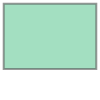

In [47]:
p = grid_df["coordinates"][0]
p

In [48]:
# calculate polygon centers
grid_df["centroid"] = grid_df.apply(lambda row: row["coordinates"].centroid, axis=1)

In [49]:
# unpack cellid
grid_df["cellid"] = grid_df.apply(lambda row: row["properties"]["cellId"], axis=1)

In [50]:
grid = grid_df[["cellid", "coordinates", "centroid"]]
grid

,cellid,coordinates,centroid
0,1,"POLYGON ((9.011491047832299 45.35880131440966,...",POINT (9.012991025904858 45.35774349047394)
1,2,"POLYGON ((9.014491488013135 45.35880097314403,...",POINT (9.015991410159719 45.35774310981321)
2,3,"POLYGON ((9.017491928134044 45.35880055306028,...",POINT (9.018991794348462 45.35774265033727)
3,4,"POLYGON ((9.020492368182619 45.35880005415845,...",POINT (9.021992178458664 45.35774211204613)
4,5,"POLYGON ((9.023492808146456 45.35879947643852,...",POINT (9.024992562477935 45.35774149493978)
...,...,...,...
9995,9996,"POLYGON ((9.297630740052327 45.56782693472525,...",POINT (9.299130880320151 45.56676539179961)
9996,9997,"POLYGON ((9.300642247414926 45.56781904882199,...",POINT (9.302142330545021 45.56675746649291)
9997,9998,"POLYGON ((9.303653753522097 45.56781108353051,...",POINT (9.305153779508254 45.56674946180095)
9998,9999,"POLYGON ((9.30666525836126 45.5678030388509, 9...",POINT (9.308165227197284 45.5667413777238)


In [58]:
ppoints = grid_df.apply(lambda row: row["coordinates"].exterior.coords, axis=1)

In [63]:
milan_polygon = MultiPoint(list(it.chain.from_iterable(ppoints)))

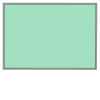

In [66]:
hull = milan_polygon.convex_hull
hull

In [ ]:
# get outer most points of all polygons
# bounds = grid_df.apply(lambda row: row["coordinates"].bounds, axis=1)
# bounds_xy = pd.DataFrame(bounds.tolist(), columns=["x_min", "y_min", "x_max", "y_max"])
# x_min, y_min, x_max, y_max = bounds_xy.agg({"x_min": np.min, "y_min": np.min, "x_max": np.max, "y_max": np.max})
# span hull between outer most points
# p1 = (x_min, y_min)
# p2 = (x_min, y_max)
# p3 = (x_max, y_min)
# p4 = (x_max, y_max)
# hull = MultiPoint([p1, p2, p3, p4]).convex_hull
# hull


_________________________________________________________
load [OpenCellid](https://opencellid.org) data to cross reference base station locations with grid coordinates.
Unfortunately historic data is not available so we use the base station data from 2021/08/04 as approximate locations
for the TIM CDR data.

#### column description
1. Radio: The generation of broadband cellular network technology
2. MCC: Mobile Country Code
3. Net: Mobile Network Code
4. Area: Location Area Code (LAC)
5. Cell: Cell tower code (CID)
6. Unit: ???
7. lat, long: Approx coordinates of the cell tower
8. range: Approximate area within which the cell could be. (radius in meters)
9. samples: No of measures processed to get this data
10. changeble:

     + 1 = The location is determined by processing samples
     + 0 = We got the location directly from the telecom firm

11. created: When the cell was first added to database (UNIX timestamp)
12. updated: When the cell was last seen (UNIX timestamp)

In [103]:
cellid_df = pd.read_csv(cellid_pth)
cellid_df


,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal
0,GSM,222,88,12031,56226,0,8.926204,44.932085,5510,22,1,1310029657,1441360675,0
1,GSM,222,88,12031,42650,0,8.897962,44.939257,32403,102,1,1310029657,1441254371,0
2,GSM,222,88,12031,42647,0,8.900029,44.948088,23649,141,1,1310029657,1443060211,0
3,GSM,222,10,10066,9422,0,8.924543,44.930649,1000,13,1,1310029657,1310435836,0
4,GSM,222,88,12032,40744,0,8.901767,44.936907,14440,40,1,1310029657,1448784109,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242476,LTE,222,1,24724,128192259,-1,10.569688,45.546284,1000,1,1,1590639354,1590639354,0
1242477,LTE,222,1,17116,180199742,-1,10.570167,45.546645,1000,2,1,1590639405,1590639425,0
1242478,LTE,222,1,17113,179901502,-1,10.574132,45.549448,1000,2,1,1590639435,1591416101,0
1242479,LTE,222,1,17116,179547966,-1,10.570567,45.546970,1000,1,1,1590639455,1590639455,0


In [104]:
# MNC from https://en.wikipedia.org/wiki/Mobile_Network_Codes_in_ITU_region_2xx_(Europe)#Italy_%E2%80%93_IT
# select only base stations of telecom italia by MNC code
tim_mnc = [1, 43, 48]
tim_cellid = cellid_df[(cellid_df["net"] == tim_mnc[0]) |
                       (cellid_df["net"] == tim_mnc[1]) |
                       (cellid_df["net"] == tim_mnc[2]) ]
tim_cellid

,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal
5,GSM,222,1,27265,57393,0,8.904054,44.907932,27303,44,1,1310029657,1379685914,0
7,GSM,222,1,27265,1626,0,8.908879,44.911198,18752,30,1,1310029657,1379727348,0
14,GSM,222,1,27265,4624,0,8.886124,44.917660,24227,88,1,1310029657,1381131915,0
15,GSM,222,1,27265,4143,0,8.924581,44.930649,1000,11,1,1310029657,1310381575,0
18,GSM,222,1,27265,57394,0,8.924606,44.930649,1000,20,1,1310029657,1310446187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242343,LTE,222,1,15110,180288318,0,12.843176,45.911442,1000,1,1,1591438977,1591438977,0
1242476,LTE,222,1,24724,128192259,-1,10.569688,45.546284,1000,1,1,1590639354,1590639354,0
1242477,LTE,222,1,17116,180199742,-1,10.570167,45.546645,1000,2,1,1590639405,1590639425,0
1242478,LTE,222,1,17113,179901502,-1,10.574132,45.549448,1000,2,1,1590639435,1591416101,0


In [105]:
# to decrease the number of possible cell towers we only select the ones with LTE support
tim_cellid = tim_cellid[tim_cellid["radio"] == "LTE"]


In [106]:
# wrap coordinates into geo points
tim_milan_cellid = tim_cellid.copy(deep=True)
tim_milan_cellid["point_coords"] = tim_cellid.apply(lambda row: Point(row[["lon", "lat"]]), axis=1)

In [107]:
# check which points are contained in Milan polygon hull
tim_milan_cellid["contained"] = tim_milan_cellid.apply(lambda row: hull.contains(row["point_coords"]), axis=1)

In [108]:
# only select those contained
tim_milan_cellid = tim_milan_cellid[tim_milan_cellid["contained"]]
tim_milan_cellid

,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal,point_coords,contained
208957,LTE,222,1,10884,128066307,0,9.260330,45.392990,1000,3,1,1422726687,1435991251,0,POINT (9.26033 45.39299),True
208964,LTE,222,1,10980,128046593,0,9.146805,45.401688,1000,1,1,1422707067,1422707067,0,POINT (9.1468048095703 45.40168762207),True
211468,LTE,222,1,10853,128188941,0,9.213409,45.519791,1000,2,1,1424024597,1434740674,0,POINT (9.213409 45.519791),True
211472,LTE,222,1,10948,128113665,0,9.243438,45.559884,1000,41,1,1424025797,1477466563,0,POINT (9.243437999999999 45.559884),True
211473,LTE,222,1,10948,128113667,0,9.232394,45.549929,1000,37,1,1424025797,1477364508,0,POINT (9.232393999999999 45.549929),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235130,LTE,222,1,24308,128265221,-1,9.163985,45.549648,1000,1,1,1578132896,1578132896,0,POINT (9.163985 45.549648),True
1238891,LTE,222,1,24307,128128002,0,9.083160,45.544785,1000,1,1,1583192794,1583192794,0,POINT (9.083159999999999 45.544785),True
1238893,LTE,222,1,24307,128092424,0,9.083152,45.544769,1000,1,1,1583227128,1583227128,0,POINT (9.083152 45.544769),True
1239080,LTE,222,1,24303,128278278,-1,9.221272,45.481203,1000,9,1,1583643067,1583645070,0,POINT (9.221272000000001 45.481203),True


In [180]:
#tim_milan_cellid["unq_id"] = tim_milan_cellid.apply(lambda row: f"{row['cell']}_{row['lon']}_{row['lat']}", axis=1)
#tim_milan_cellid["unq_id"].nunique()

<ipython-input-180-bf8f9488e0f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tim_milan_cellid["unq_id"] = tim_milan_cellid.apply(lambda row: f"{row['cell']}_{row['lon']}_{row['lat']}", axis=1)


In [102]:
#tim_milan_cellid.drop_duplicates(subset="unq_id", inplace=True)
#tim_milan_cellid
#tim_milan_cellid[tim_milan_cellid["radio"] == "LTE"]

,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal,point_coords,contained
208957,LTE,222,1,10884,128066307,0,9.260330,45.392990,1000,3,1,1422726687,1435991251,0,POINT (9.26033 45.39299),True
208964,LTE,222,1,10980,128046593,0,9.146805,45.401688,1000,1,1,1422707067,1422707067,0,POINT (9.1468048095703 45.40168762207),True
211468,LTE,222,1,10853,128188941,0,9.213409,45.519791,1000,2,1,1424024597,1434740674,0,POINT (9.213409 45.519791),True
211472,LTE,222,1,10948,128113665,0,9.243438,45.559884,1000,41,1,1424025797,1477466563,0,POINT (9.243437999999999 45.559884),True
248822,LTE,222,1,61226,80377309,490,9.132148,45.370728,1000,2,1,1439930387,1560598701,0,POINT (9.132148000000001 45.370728),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235121,LTE,222,1,24272,128337669,-1,9.188133,45.501873,1000,1,1,1578132602,1578132602,0,POINT (9.188133000000001 45.501873),True
1235125,LTE,222,1,24272,128530692,-1,9.172047,45.523293,1000,1,1,1578132749,1578132749,0,POINT (9.172046999999999 45.523293),True
1235127,LTE,222,1,24308,128530694,-1,9.169231,45.525436,1000,1,1,1578132762,1578132762,0,POINT (9.169231 45.525436),True
1235129,LTE,222,1,24308,128628742,-1,9.163039,45.547525,1000,11,1,1578132868,1578132911,0,POINT (9.163038999999999 45.547525),True


In [109]:
tim_milan_cellid["cell"].nunique()

2751

In [110]:
# drop duplicate entries of Cell tower code which are the same position just different radio band
tim_milan_cellid.drop_duplicates(subset="cell", inplace=True)
tim_milan_cellid

,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal,point_coords,contained
208957,LTE,222,1,10884,128066307,0,9.260330,45.392990,1000,3,1,1422726687,1435991251,0,POINT (9.26033 45.39299),True
208964,LTE,222,1,10980,128046593,0,9.146805,45.401688,1000,1,1,1422707067,1422707067,0,POINT (9.1468048095703 45.40168762207),True
211468,LTE,222,1,10853,128188941,0,9.213409,45.519791,1000,2,1,1424024597,1434740674,0,POINT (9.213409 45.519791),True
211472,LTE,222,1,10948,128113665,0,9.243438,45.559884,1000,41,1,1424025797,1477466563,0,POINT (9.243437999999999 45.559884),True
211473,LTE,222,1,10948,128113667,0,9.232394,45.549929,1000,37,1,1424025797,1477364508,0,POINT (9.232393999999999 45.549929),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235121,LTE,222,1,24272,128337669,-1,9.188133,45.501873,1000,1,1,1578132602,1578132602,0,POINT (9.188133000000001 45.501873),True
1235125,LTE,222,1,24272,128530692,-1,9.172047,45.523293,1000,1,1,1578132749,1578132749,0,POINT (9.172046999999999 45.523293),True
1235127,LTE,222,1,24308,128530694,-1,9.169231,45.525436,1000,1,1,1578132762,1578132762,0,POINT (9.169231 45.525436),True
1235129,LTE,222,1,24308,128628742,-1,9.163039,45.547525,1000,11,1,1578132868,1578132911,0,POINT (9.163038999999999 45.547525),True


In [111]:
possible_bs_coord = tim_milan_cellid.reset_index()[["lon", "lat", "point_coords"]]
points = MultiPoint(possible_bs_coord["point_coords"])
possible_bs_coord["bs_id"] = possible_bs_coord.index

In [112]:
# function selecting closest base station to center of each square
def get_base_station(orig: Point, p_union: MultiPoint, df):
    p = nearest_points(orig, p_union)[-1]
    msk = df["point_coords"] == p
    return df[msk].iloc[0]

In [113]:
grid[["x", "y", "bs_point_coords", "bs_org_id"]] = grid.apply(lambda row: get_base_station(
    orig=row["centroid"], p_union=points, df=possible_bs_coord
), axis=1)
grid

,coordinates,centroid,x,y,bs_point_coords,bs_org_id
cellid,,,,,,
1,"POLYGON ((9.011491047832299 45.35880131440966,...",POINT (9.012991025904858 45.35774349047394),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
2,"POLYGON ((9.014491488013135 45.35880097314403,...",POINT (9.015991410159719 45.35774310981321),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
3,"POLYGON ((9.017491928134044 45.35880055306028,...",POINT (9.018991794348462 45.35774265033727),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
4,"POLYGON ((9.020492368182619 45.35880005415845,...",POINT (9.021992178458664 45.35774211204613),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
5,"POLYGON ((9.023492808146456 45.35879947643852,...",POINT (9.024992562477935 45.35774149493978),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
...,...,...,...,...,...,...
9996,"POLYGON ((9.297630740052327 45.56782693472525,...",POINT (9.299130880320151 45.56676539179961),9.303360,45.566483,POINT (9.3033599853516 45.566482543945),321
9997,"POLYGON ((9.300642247414926 45.56781904882199,...",POINT (9.302142330545021 45.56675746649291),9.303360,45.566483,POINT (9.3033599853516 45.566482543945),321
9998,"POLYGON ((9.303653753522097 45.56781108353051,...",POINT (9.305153779508254 45.56674946180095),9.303360,45.566483,POINT (9.3033599853516 45.566482543945),321


In [114]:
grid["bs_org_id"].nunique()
# -> 2020 for only LTE (5159 for all) unique base stations positioned in and around the Milan area

2020

In [115]:
# save enhanced grid to be possibly reused with traffic data of different days
grid.to_csv(save_grid_pth, index=True)


_________________________________________________________
use enhanced grid to group squares by respective base station and aggregate workloads accordingly

In [116]:
grid

,coordinates,centroid,x,y,bs_point_coords,bs_org_id
cellid,,,,,,
1,"POLYGON ((9.011491047832299 45.35880131440966,...",POINT (9.012991025904858 45.35774349047394),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
2,"POLYGON ((9.014491488013135 45.35880097314403,...",POINT (9.015991410159719 45.35774310981321),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
3,"POLYGON ((9.017491928134044 45.35880055306028,...",POINT (9.018991794348462 45.35774265033727),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
4,"POLYGON ((9.020492368182619 45.35880005415845,...",POINT (9.021992178458664 45.35774211204613),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
5,"POLYGON ((9.023492808146456 45.35879947643852,...",POINT (9.024992562477935 45.35774149493978),9.014969,45.361862,POINT (9.0149688720703 45.361862182617),2005
...,...,...,...,...,...,...
9996,"POLYGON ((9.297630740052327 45.56782693472525,...",POINT (9.299130880320151 45.56676539179961),9.303360,45.566483,POINT (9.3033599853516 45.566482543945),321
9997,"POLYGON ((9.300642247414926 45.56781904882199,...",POINT (9.302142330545021 45.56675746649291),9.303360,45.566483,POINT (9.3033599853516 45.566482543945),321
9998,"POLYGON ((9.303653753522097 45.56781108353051,...",POINT (9.305153779508254 45.56674946180095),9.303360,45.566483,POINT (9.3033599853516 45.566482543945),321


In [117]:
traffic_df

,square_id,internet
1,1,0.052275
2,1,0.027300
4,1,0.133637
6,1,0.054601
8,1,0.053438
...,...,...
4842617,9999,0.438452
4842619,9999,0.144481
4842622,9999,0.014708
4842623,9999,0.085995


In [118]:
# replace index with cellid for join (which uses index)
grid.set_index("cellid", inplace=True)

KeyError: "None of ['cellid'] are in the columns"

In [119]:
# join grid and traffic data
bs_traffic_data = traffic_df.join(grid[["x", "y", "bs_org_id"]], on="square_id")
bs_traffic_data

,square_id,internet,x,y,bs_org_id
1,1,0.052275,9.014969,45.361862,2005
2,1,0.027300,9.014969,45.361862,2005
4,1,0.133637,9.014969,45.361862,2005
6,1,0.054601,9.014969,45.361862,2005
8,1,0.053438,9.014969,45.361862,2005
...,...,...,...,...,...
4842617,9999,0.438452,9.309206,45.562402,9
4842619,9999,0.144481,9.309206,45.562402,9
4842622,9999,0.014708,9.309206,45.562402,9
4842623,9999,0.085995,9.309206,45.562402,9


In [120]:
# group df by location id to get different base stations
grp_data = bs_traffic_data.groupby(["bs_org_id"])

In [121]:
# aggregate session lengths
bs_table = grp_data.agg({
    "square_id": lambda x: x.count(),   # interpret count of connections as approx number of users
    "internet": [np.sum, np.mean],
    "x": lambda x: x.iloc[0],
    "y": lambda x: x.iloc[0],
})
bs_table

square_id     internet                   x          y
           <lambda>          sum      mean  <lambda>   <lambda>
bs_org_id                                                      
0               798  1000.980770  1.254362  9.260330  45.392990
1              1664  3206.357522  1.926898  9.146805  45.401688
2               559  1960.867676  3.507813  9.213409  45.519791
3               346   381.208988  1.101760  9.243438  45.559884
4               325   837.206373  2.576020  9.232394  45.549929
...             ...          ...       ...       ...        ...
2742           1004  3778.433320  3.763380  9.187517  45.494183
2744            955  4153.051634  4.348745  9.186849  45.498079
2747            644  1553.643933  2.412491  9.172047  45.523293
2748            345   739.342531  2.143022  9.169231  45.525436
2750           3612  2430.388491  0.672865  9.083160  45.544785

[2020 rows x 5 columns]

In [122]:
bs_table.reset_index(inplace=True)
bs_table

bs_org_id square_id     internet                   x          y
                <lambda>          sum      mean  <lambda>   <lambda>
0            0       798  1000.980770  1.254362  9.260330  45.392990
1            1      1664  3206.357522  1.926898  9.146805  45.401688
2            2       559  1960.867676  3.507813  9.213409  45.519791
3            3       346   381.208988  1.101760  9.243438  45.559884
4            4       325   837.206373  2.576020  9.232394  45.549929
...        ...       ...          ...       ...       ...        ...
2015      2742      1004  3778.433320  3.763380  9.187517  45.494183
2016      2744       955  4153.051634  4.348745  9.186849  45.498079
2017      2747       644  1553.643933  2.412491  9.172047  45.523293
2018      2748       345   739.342531  2.143022  9.169231  45.525436
2019      2750      3612  2430.388491  0.672865  9.083160  45.544785

[2020 rows x 6 columns]

In [123]:
bs_table.describe()


bs_org_id     square_id      internet                         x  \
                        <lambda>           sum         mean     <lambda>   
count  2020.000000   2020.000000   2020.000000  2020.000000  2020.000000   
mean   1328.403960   1104.756931   1582.555599     2.249301     9.181048   
std     791.473984   1772.120093   1312.033596     1.840666     0.065195   
min       0.000000     48.000000     13.466486     0.070629     9.011536   
25%     613.750000    341.750000    678.233962     0.910364     9.138822   
50%    1349.000000    641.000000   1286.638581     1.694617     9.184459   
75%    2003.250000   1273.250000   2060.797545     3.121914     9.227872   
max    2750.000000  38090.000000  11880.566761    17.459901     9.311943   

                 y  
          <lambda>  
count  2020.000000  
mean     45.479163  
std       0.045153  
min      45.356369  
25%      45.451105  
50%      45.479965  
75%      45.512924  
max      45.567959

In [124]:
# rename columns
bs_table.columns = [
    "bs_id",
    "num_users",
    "workload",
    "workload_mean",
    "x_coord",
    "y_coord"
]

In [125]:
# replace orig_bs_id with index from 0 to N-1
bs_table["bs_id"] = bs_table.index
bs_table

,bs_id,num_users,workload,workload_mean,x_coord,y_coord
0,0,798,1000.980770,1.254362,9.260330,45.392990
1,1,1664,3206.357522,1.926898,9.146805,45.401688
2,2,559,1960.867676,3.507813,9.213409,45.519791
3,3,346,381.208988,1.101760,9.243438,45.559884
4,4,325,837.206373,2.576020,9.232394,45.549929
...,...,...,...,...,...,...
2015,2015,1004,3778.433320,3.763380,9.187517,45.494183
2016,2016,955,4153.051634,4.348745,9.186849,45.498079
2017,2017,644,1553.643933,2.412491,9.172047,45.523293
2018,2018,345,739.342531,2.143022,9.169231,45.525436


In [126]:
# save aggregated raw data
bs_table.to_csv(save_raw_pth, index=False)


Do some prior analysis and plots

In [129]:
bs_table = pd.read_csv(save_raw_pth)
bs_table



,bs_id,num_users,workload,workload_mean,x_coord,y_coord
0,0,798,1000.980770,1.254362,9.260330,45.392990
1,1,1664,3206.357522,1.926898,9.146805,45.401688
2,2,559,1960.867676,3.507813,9.213409,45.519791
3,3,346,381.208988,1.101760,9.243438,45.559884
4,4,325,837.206373,2.576020,9.232394,45.549929
...,...,...,...,...,...,...
2015,2015,1004,3778.433320,3.763380,9.187517,45.494183
2016,2016,955,4153.051634,4.348745,9.186849,45.498079
2017,2017,644,1553.643933,2.412491,9.172047,45.523293
2018,2018,345,739.342531,2.143022,9.169231,45.525436


In [130]:
bs_table.describe()


,bs_id,num_users,workload,workload_mean,x_coord,y_coord
count,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000
mean,1009.500000,1104.756931,1582.555599,2.249301,9.181048,45.479163
std,583.268092,1772.120093,1312.033596,1.840666,0.065195,0.045153
min,0.000000,48.000000,13.466486,0.070629,9.011536,45.356369
25%,504.750000,341.750000,678.233962,0.910364,9.138822,45.451105
50%,1009.500000,641.000000,1286.638581,1.694617,9.184459,45.479965
75%,1514.250000,1273.250000,2060.797545,3.121914,9.227872,45.512924
max,2019.000000,38090.000000,11880.566761,17.459901,9.311943,45.567959


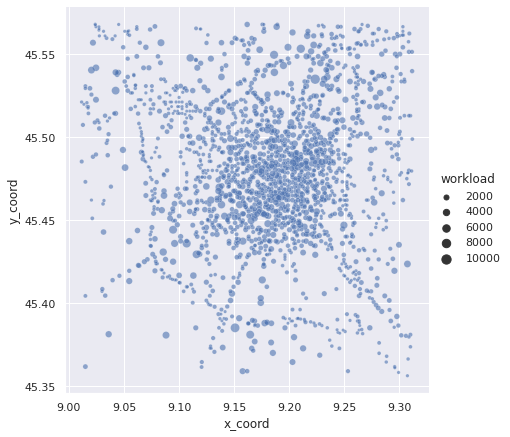

In [131]:
sns.relplot(x="x_coord", y="y_coord", size="workload",
            sizes=(10, 100), alpha=.6, palette="muted",
            height=6, data=bs_table)


Normalize data


In [132]:
bs_table = pd.read_csv(save_raw_pth)
bs_table

,bs_id,num_users,workload,workload_mean,x_coord,y_coord
0,0,798,1000.980770,1.254362,9.260330,45.392990
1,1,1664,3206.357522,1.926898,9.146805,45.401688
2,2,559,1960.867676,3.507813,9.213409,45.519791
3,3,346,381.208988,1.101760,9.243438,45.559884
4,4,325,837.206373,2.576020,9.232394,45.549929
...,...,...,...,...,...,...
2015,2015,1004,3778.433320,3.763380,9.187517,45.494183
2016,2016,955,4153.051634,4.348745,9.186849,45.498079
2017,2017,644,1553.643933,2.412491,9.172047,45.523293
2018,2018,345,739.342531,2.143022,9.169231,45.525436


In [133]:
# normalize coordinates
bs_table["x_coord"] = bs_table["x_coord"] - bs_table["x_coord"].min()
bs_table["y_coord"] = bs_table["y_coord"] - bs_table["y_coord"].min()
max_val = max(bs_table["x_coord"].max(), bs_table["y_coord"].max())
bs_table["x_coord"] = bs_table["x_coord"] / max_val
bs_table["y_coord"] = bs_table["y_coord"] / max_val
bs_table.describe()

,bs_id,num_users,workload,workload_mean,x_coord,y_coord
count,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000
mean,1009.500000,1104.756931,1582.555599,2.249301,0.564275,0.408759
std,583.268092,1772.120093,1312.033596,1.840666,0.217022,0.150305
min,0.000000,48.000000,13.466486,0.070629,0.000000,0.000000
25%,504.750000,341.750000,678.233962,0.910364,0.423713,0.315357
50%,1009.500000,641.000000,1286.638581,1.694617,0.575629,0.411429
75%,1514.250000,1273.250000,2060.797545,3.121914,0.720143,0.521144
max,2019.000000,38090.000000,11880.566761,17.459901,1.000000,0.704344


In [134]:
# The maximum capacity is given by total workload divided by number of edge servers times a factor
# the factor controls how tight the capacity constraint is
max_cap_factors = [1.05, 1.1, 1.2, 1.5]
k = 25  # we fix the number of ES to 25
total_workload = bs_table["workload"].sum()


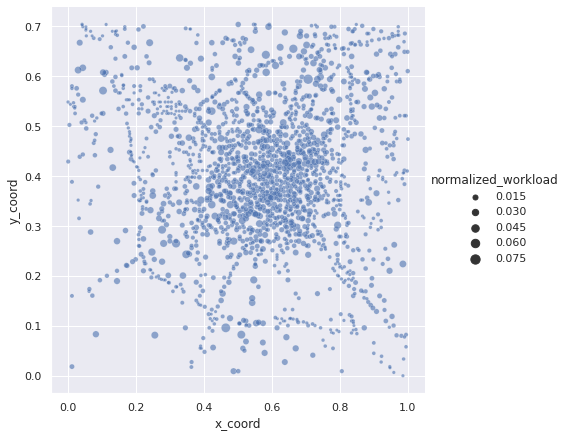

In [137]:
normalizer = np.ceil((total_workload / k) * 1.05)
bs_table["normalized_workload"] = bs_table["workload"] / normalizer
sns.relplot(x="x_coord", y="y_coord", size="normalized_workload",
            sizes=(10, 100), alpha=.6, palette="muted",
            height=6, data=bs_table)


In [135]:
# normalize with different capacity factors and save as np array
for f in max_cap_factors:
    # normalize workload
    normalizer = np.ceil((total_workload / k) * f)
    bs_table["normalized_workload"] = bs_table["workload"] / normalizer
    save_table = bs_table[["num_users", "x_coord", "y_coord", "normalized_workload"]]
    # save as csv
    save_table.to_csv(os.path.join(save_norm_pth, f"data_norm_cap{f}_.csv"))
    # convert to numpy array
    save_array = save_table.to_numpy(copy=True)
    # save as serialized data
    Generator.save_dataset(save_array, filepath=os.path.join(save_norm_pth, f"data_norm_cap{f}_.dat"))


Saving dataset to:  data/CCP/benchmark/telecom_italia/data_norm_cap1.05_.dat
Saving dataset to:  data/CCP/benchmark/telecom_italia/data_norm_cap1.1_.dat
Saving dataset to:  data/CCP/benchmark/telecom_italia/data_norm_cap1.2_.dat
Saving dataset to:  data/CCP/benchmark/telecom_italia/data_norm_cap1.5_.dat
